In [1]:
# Re-implement using pure shapely + rasterio (no geopandas) to avoid array-interface issues
import os, re, json, glob, math, warnings
import sys
import geopandas as gpd
import pathlib
from dataclasses import dataclass
import numpy as np
import pandas as pd
import rasterio
from rasterio.enums import Resampling
from rasterio.features import shapes, rasterize
from shapely.geometry import shape as shp_shape, mapping, Polygon, MultiPolygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import contextily as cx
from scipy.ndimage import binary_opening, binary_closing, binary_fill_holes, label
import xml.etree.ElementTree
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
raw_fold_drive = "G"

if sys.platform == 'darwin':
    print('mac')
    raw_fold = pathlib.Path('/users/ink/Google Drive/My Drive/WORK/Milford/')
else:
    print('pc')
    raw_fold = pathlib.Path(f'{raw_fold_drive}:/My Drive/WORK/Milford/')
planet_fold = raw_fold / 'Planet'


mac


In [3]:
polys = gpd.read_file("pou.gpkg").to_crs("EPSG:32612")
polys['OBJECTID'] = range(len(polys))
polys.to_file("pou_ids.gpkg")

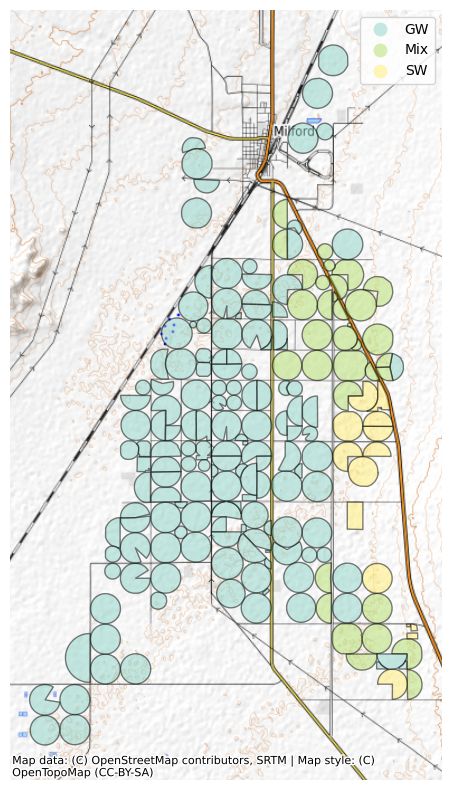

In [4]:
pou = gpd.read_file("pou_ids.gpkg")

#pou.to_file("pou.gpkg")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
pou.to_crs(epsg=3857).plot(ax=ax, alpha=0.5, edgecolor='k',
                           column='WaterSourc',
          legend=True,
          cmap='Set3',
          figsize=(10,10)) # Plot your GeoDataFrame
cx.add_basemap(ax, zoom=12, source=cx.providers.OpenTopoMap) # Add the basemap
ax.set_axis_off() # Optional: Hide the axis labels and ticks
plt.show()


In [11]:
def _coeffs_from_xml(xml_path: pathlib.Path) -> dict[int, float]:
    """Return {band_index(1-based): reflectanceCoefficient} from a Planet XML."""
    coeffs = {}
    try:
        root = xml.etree.ElementTree.parse(str(xml_path)).getroot()
        for node in root.findall('.//{*}bandSpecificMetadata'):
            b = node.find('.//{*}bandNumber')
            c = node.find('.//{*}reflectanceCoefficient')
            if b is not None and c is not None:
                try:
                    coeffs[int(b.text.strip())] = float(c.text.strip())
                except Exception:
                    pass
    except Exception:
        pass
    return coeffs

def scale_with_xml(
    masked_raster: np.ndarray,
    xml_path: str | pathlib.Path,
    band_index: int | None = None,
    out_tif: str | pathlib.Path | None = None,
    template_tif: str | pathlib.Path | None = None
    ) -> np.ndarray: # type: ignore
        """Scale a masked raster using Planet reflectance coefficients from XML.
        
        Parameters
        ----------
        masked_raster : np.ndarray
            Your raster as a NumPy array. NaNs are preserved. Can be 2D (single-band)
            or 3D (bands, rows, cols). If 3D, scaling is applied per-band when possible.
        xml_path : str or Path
            Path to the Planet metadata XML containing <reflectanceCoefficient> per band.
        band_index : int, optional
            1-based band index whose coefficient should be used. Required if masked_raster is 2D
            and you want a specific band's coefficient. If masked_raster is 3D and band_index is None,
            the function attempts to scale each band i with coefficient (i+1).
        out_tif : str or Path, optional
            If given, write a GeoTIFF of the scaled raster (requires template_tif for geo metadata).
        template_tif : str or Path, optional
            A GeoTIFF to copy georeferencing/transform/profile from when writing out_tif.
        
        Returns
        -------
        np.ndarray
            Scaled raster (float32), preserving NaNs.
        """
        coeffs = _coeffs_from_xml(pathlib.Path(xml_path))
        arr = masked_raster.astype('float32', copy=True)
        
        if arr.ndim == 2:
            if band_index is None:
                raise ValueError("For a single-band array, provide band_index (1-based) to select a coefficient.")
            coeff = coeffs.get(int(band_index))
            if coeff is None:
                scaled = arr
            else:
                finite = np.isfinite(arr)
                scaled = np.full_like(arr, np.nan, dtype='float32')
                scaled[finite] = arr[finite] * float(coeff)
        elif arr.ndim == 3:
            scaled = np.full_like(arr, np.nan, dtype='float32')
            bands = arr.shape[0]
            for i in range(bands):
                c = coeffs.get(i+1)
                if c is None:
                    scaled[i] = arr[i]
                else:
                    finite = np.isfinite(arr[i])
                    scaled[i, finite] = arr[i, finite] * float(c)
        else:
            raise ValueError("masked_raster must be 2D or 3D.")

        if out_tif is not None:
            if template_tif is None:
                raise ValueError("template_tif is required when writing an output GeoTIFF.")
            with rasterio.open(template_tif) as tmpl:
                profile = tmpl.profile.copy()
                if scaled.ndim == 2:
                    profile.update(count=1, dtype='float32', nodata=np.nan)
                    with rasterio.open(out_tif, 'w', **profile) as dst:
                        dst.write(scaled, 1)
                else:
                    profile.update(count=scaled.shape[0], dtype='float32', nodata=np.nan)
                    with rasterio.open(out_tif, 'w', **profile) as dst:
                        dst.write(scaled)
        return scaled

def parse_date_from_path(path):
    base = os.path.basename(path)
    m = re.search(r"(20\d{2}-\d{2}-\d{2})", base)
    if m:
        return pd.to_datetime(m.group(1)).date()
    js = re.sub(r"\.tif$", "_metadata.json", path)
    if os.path.exists(js):
        try:
            meta = json.load(open(js))
            acq = meta.get("properties", {}).get("acquired")
            if acq: return pd.to_datetime(acq).date()
        except Exception: pass
    return None

def get_ndvi(src, mask=None, xml=None):
    red = src.read(6).astype("float32")
    nir = src.read(8).astype("float32")
    if mask is not None:
        red = np.where(mask, red, np.nan)
        nir = np.where(mask, nir, np.nan)
    if xml is not None:
        red = scale_with_xml(red, xml_path=xml, band_index=6)
        nir = scale_with_xml(nir, xml_path=xml, band_index=8)
    den = nir + red
    ndvi = np.full_like(nir, np.nan, dtype="float32")
    valid = den != 0
    ndvi[valid] = (nir[valid] - red[valid]) / den[valid]
    return ndvi

def get_transform(src):
    transform = src.transform
    crs = src.crs
    xres = transform.a
    yres = -transform.e if transform.e < 0 else transform.e
    pixel_size = (xres, yres)
    return transform, crs, pixel_size

def read_udm_mask(udm_path:pathlib.Path):
    with rasterio.open(udm_path) as src:
        udm = src.read(1)
        mask = (udm == 1)
    return mask

def make_ndvi(composite_path:pathlib.Path, 
                    xml_path: pathlib.Path | None = None, 
                    udm_path: pathlib.Path | None = None):
    mask = read_udm_mask(udm_path) 
    with rasterio.open(composite_path) as src:
        ndvi = get_ndvi(src, mask=mask, xml=xml_path)
        transform, crs, pixel_size = get_transform(src)
        profile = src.profile.copy()
        profile.update(count=1, dtype="float32", nodata=np.nan)
        return ndvi, profile, transform, crs, pixel_size






def polygon_metrics(poly):
    A = poly.area
    Pp = poly.length
    if Pp==0: return 0.0, 0.0
    circ = 4*np.pi*A/(Pp*Pp)
    r_equiv = np.sqrt(A/np.pi)
    return float(circ), float(r_equiv)

def raster_mask_from_ndvi(ndvi, thresh, min_pixels):
    
    m = (ndvi>=thresh) & np.isfinite(ndvi)
    m = binary_opening(m, structure=np.ones((3,3)))
    m = binary_closing(m, structure=np.ones((5,5)))
    m = binary_fill_holes(m)
    lab, n = label(m) # type: ignore
    if n>0:
        cnt = np.bincount(lab.ravel())
        small = np.isin(lab, np.where(cnt<min_pixels)[0])
        m[small] = False
    return m

def zonal_ndvi(ndvi, polys, transform):
    ids = list(range(1, len(polys)+1))
    lid = rasterize(
        shapes=[(mapping(g), pid) for g, pid in zip(polys, ids)],
        out_shape=ndvi.shape,
        transform=transform,
        fill=0, dtype="int32", all_touched=False
    )
    rows = []
    for pid in ids:
        m = (lid==pid)
        if m.any():
            v = ndvi[m]
            rows.append(dict(pivot_id=pid,
                             ndvi_mean=float(np.nanmean(v)),
                             ndvi_p50=float(np.nanpercentile(v,50)),
                             ndvi_p90=float(np.nanpercentile(v,90)),
                             n_pix=int(np.isfinite(v).sum())))
        else:
            rows.append(dict(pivot_id=pid, ndvi_mean=np.nan, ndvi_p50=np.nan, ndvi_p90=np.nan, n_pix=0))
    return pd.DataFrame(rows)


In [6]:
for tif in raw_fold.glob("*composite.tif"):
    udm_path = pathlib.Path(str(tif)[:-4] + "_udm2.tif")
    xmls = list(raw_fold.glob("*.xml"))
    for xml in xmls:
        matches = []
        dt = parse_date_from_path(tif)
        strdate = f"{dt:%Y%m%d}"
        if strdate in str(xml):
            matches.append(xml)
        xml_path = matches[0] if matches else None
        if xml_path:
            print(strdate)
            xml_path = pathlib.Path(xml_path)
    if udm_path.exists():
        print(tif)
        dt = parse_date_from_path(tif)
        ndvi, profile, transform, crs, pixel_size = make_ndvi(tif, xml_path=xml_path, udm_path=udm_path)
        print(f"NDVI: {ndvi}, Profile: {profile}, Transform: {transform}, CRS: {crs}, Pixel Size: {pixel_size}")
        out_tif = tif.parents[0] / f"{dt:%Y%m%d}_ndvi.tif"
        with rasterio.open(out_tif, 'w', **profile) as dst:
            dst.write(ndvi, 1)


20240809
20240809
20240809
/users/ink/Google Drive/My Drive/WORK/Milford/Planet/2024-08-09_strip_7497591_composite.tif
NDVI: [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]], Profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 3819, 'height': 6538, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 12N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS

AttributeError: 'Axes' object has no attribute 'cmap'

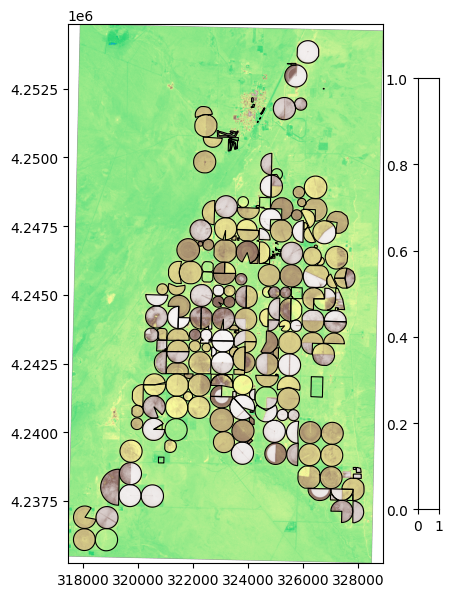

In [12]:
# Minimal raster + GeoPackage overlay in one cell

import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show as rioshow

# --- paths (edit these) ---
raster_path = "/users/ink/Google Drive/My Drive/WORK/Milford/Planet/20240710_ndvi.tif"
gpkg_path   = "pou_ids.gpkg"
gpkg_layer  = None  # or e.g. "parcels"

# --- read raster ---
with rasterio.open(raster_path) as src:
    band = src.read(1, masked=True)       # nodata respected
    r_crs = src.crs
    r_transform = src.transform

# --- read vector ---
gdf = gpd.read_file(gpkg_path, layer=gpkg_layer)

# align CRS (project vector to raster CRS)
if gdf.crs is None:
    gdf = gdf.set_crs(r_crs)
elif gdf.crs != r_crs:
    gdf = gdf.to_crs(r_crs)

# --- plot ---
fig, ax = plt.subplots(figsize=(9, 7))

# raster first
im = rioshow(band, transform=r_transform, ax=ax, cmap="terrain", alpha=0.95)

# vector on top (works for points/lines/polygons)
if not gdf.empty:
    gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=0.8)

# cosmetics
cbar = fig.colorbar(im, ax=ax, shrink=0.8, label="Band 1")
ax.set_title("Raster + GPKG overlay")
ax.set_xlabel(f"CRS: {r_crs.to_string() if r_crs else 'unknown'}")
ax.set_ylabel("")
plt.tight_layout()
plt.show()


In [13]:
from rasterstats import zonal_stats

zonal_dfs = {}

for ndvi in planet_fold.glob("*_ndvi.tif"):
    dt =str(ndvi.stem).split("_")[0]
    try:
        ndvi_vals = zonal_stats(polys,
                                    str(ndvi), 
                                    stats="mean")
        ndvis = [v['mean'] for v in ndvi_vals]
        zonal_dfs[dt] = ndvis
    except Exception as e:
        print(f"Error processing {ndvi.stem}: {e}")
        pass
ndvi_df = pd.DataFrame.from_dict(zonal_dfs, orient="columns")


In [14]:
pl = polys['OBJECTID'].to_dict()
ndvi_df['OBJECTID'] = ndvi_df.index.map(pl)
ndvi_df = ndvi_df.set_index('OBJECTID')
ndvi_df = ndvi_df.stack().rename("ndvi").reset_index().rename(columns={'level_1':'date'})
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df = ndvi_df.set_index(['OBJECTID', 'date']).sort_index()

ndvi_df.to_csv("pou_ndvi_timeseries.csv")

<Axes: title={'center': 'NDVI Time Series for 14, a corn field'}, xlabel='Date', ylabel='NDVI'>

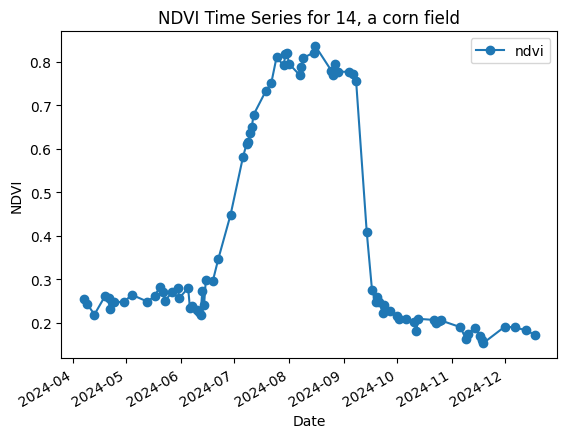

In [30]:
id = 14
ndvi_df.loc[id].plot(marker='o', 
                       title=f"NDVI Time Series for {id}, a corn field", 
                       ylabel="NDVI", 
                       xlabel="Date")

In [16]:
# Load the CSV, build functions to classify plot type, and detect alfalfa cut dates.
import pandas as pd
import numpy as np
from datetime import timedelta

# ---- Load data ----
path = "pou_ndvi_timeseries.csv"
df = pd.read_csv(path)

# Try to normalize column names and index
# Expect columns like: field_id, date (or timestamp), ndvi
cols = {c.lower().strip(): c for c in df.columns}
# Find likely columns
fid_col = None
date_col = None
ndvi_col = None
for c in df.columns:
    cl = c.lower().strip()
    if fid_col is None and ("field" in cl and "id" in cl):
        fid_col = c
    if date_col is None and (cl in ("date","time","timestamp","datetime") or "date" in cl or "time" in cl):
        date_col = c
    if ndvi_col is None and ("ndvi" in cl):
        ndvi_col = c

# Fallbacks if not found
fid_col = fid_col or df.columns[0]
# Prefer a likely datetime column
if date_col is None:
    # Heuristic: pick the first column that parses as datetime well
    for c in df.columns:
        try:
            pd.to_datetime(df[c])
            date_col = c
            break
        except Exception:
            continue
if ndvi_col is None:
    # try last column
    ndvi_col = df.columns[-1]

# Parse datetime and sort
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values([fid_col, date_col])

# Clean NDVI values (clip to sensible range)
df[ndvi_col] = pd.to_numeric(df[ndvi_col], errors="coerce").clip(lower=0, upper=1)

# Build MultiIndex
df = df.set_index([fid_col, date_col]).sort_index()

# ---- Helper functions ----
def _regularize_series(s: pd.Series, freq="5D") -> pd.Series:
    """Resample to a regular grid with median aggregation, forward-fill small gaps, and smooth lightly."""
    sr = s.resample(freq).median()
    # Forward/back fill small gaps (<= 2 steps)
    sr = sr.ffill(limit=2).bfill(limit=2)
    # Light smoothing: centered rolling median then mean
    sm = sr.rolling(3, center=True, min_periods=1).median()
    sm = sm.rolling(3, center=True, min_periods=1).mean()
    return sm

def detect_alfalfa_cuts(series: pd.Series,
                        drop_thresh: float = 0.15,
                        pre_min: float = 0.55,
                        recovery: float = 0.10,
                        min_spacing_days: int = 18) -> list:
    """
    Detect likely alfalfa cut dates as sharp drops from a high NDVI followed by recovery.
    Heuristics only—tuned for irrigated alfalfa in semi-arid settings.
    """
    s = _regularize_series(series)
    if s.dropna().empty:
        return []
    cuts = []
    min_spacing = pd.Timedelta(days=min_spacing_days)

    # For each time, compare current value to prior 15 days max; drop >= drop_thresh and prior >= pre_min.
    win = 15  # days, but our frequency is ~5D, so use 3 steps either side
    # Use rolling window based on time deltas rather than fixed count
    # implement with expanding max of last 30 days sampled from s.index
    for i, t in enumerate(s.index):
        val = s.iloc[i]
        if pd.isna(val):
            continue
        # Prior window max over ~20 days
        t0 = t - pd.Timedelta(days=25)
        prior = s.loc[(s.index >= t0) & (s.index < t)]
        if prior.empty:
            continue
        prior_max = prior.max()
        # Drop size
        drop_val = prior_max - val
        if np.isnan(prior_max) or np.isnan(drop_val):
            continue
        if drop_val >= drop_thresh and prior_max >= pre_min:
            # Ensure recovery within next ~25 days
            t1 = t + pd.Timedelta(days=25)
            future = s.loc[(s.index > t) & (s.index <= t1)]
            recov = future.max() - val if not future.empty else 0.0
            if recov >= recovery:
                # Debounce: avoid marking multiple points in the same event; choose local minimum in ±10 days
                start = t - pd.Timedelta(days=10)
                end = t + pd.Timedelta(days=10)
                window = s.loc[(s.index >= start) & (s.index <= end)]
                if not window.empty:
                    local_min_time = window.idxmin()
                    # Enforce spacing
                    if not cuts or (local_min_time - cuts[-1]) >= min_spacing:
                        cuts.append(local_min_time)
    return sorted(list(dict.fromkeys(cuts)))  # unique and sorted

def classify_plot(series: pd.Series) -> dict:
    """
    Classify a single field's NDVI time series into {'alfalfa','corn','fallow','unknown'}.
    Returns features used for transparency.
    """
    s = _regularize_series(series)
    if s.dropna().empty:
        return {"type": "unknown", "cuts": [], "peak": np.nan, "median": np.nan, "peak_date": pd.NaT}
    cuts = detect_alfalfa_cuts(series)
    peak = float(s.max())
    median = float(s.median())
    peak_date = s.idxmax()

    # Early and late season medians to help distinguish corn ramp
    # early: April–June 15; late: July 1–Sep 30
    early = s.loc[(s.index.month <= 6) & (s.index.day <= 15) | (s.index.month < 6)]
    late = s.loc[(s.index.month >= 7) & (s.index.month <= 9)]
    early_med = float(early.median()) if not early.empty else np.nan
    late_med = float(late.median()) if not late.empty else np.nan

    # Simple rules
    if (peak < 0.5 and median < 0.35) or (np.nan_to_num(peak) < 0.45):
        ptype = "fallow"
    elif len(cuts) >= 2 and peak >= 0.7:
        ptype = "alfalfa"
    elif len(cuts) <= 1 and peak >= 0.7:
        # Corn tends to have low early season and a single mid/late summer peak
        if pd.notna(peak_date) and (peak_date.month in (7,8,9)) and (np.isnan(early_med) or early_med < 0.4) and (np.isnan(late_med) or late_med >= 0.55):
            ptype = "corn"
        else:
            ptype = "corn"
    else:
        # Fallbacks
        ptype = "fallow" if median < 0.4 else ("alfalfa" if len(cuts) >= 2 else "corn")
    return {"type": ptype, "cuts": cuts, "peak": peak, "median": median, "peak_date": peak_date,
            "early_med": early_med, "late_med": late_med, "num_cuts": len(cuts)}

def classify_all(df_multi: pd.DataFrame, ndvi_col: str) -> pd.DataFrame:
    """Apply classification for each field_id; return a tidy dataframe with features."""
    out = []
    for fid, sdf in df_multi.groupby(level=0):
        series = sdf[ndvi_col].droplevel(0)
        feat = classify_plot(series)
        row = {"field_id": fid, "type": feat["type"], "num_cuts": feat["num_cuts"],
               "peak_ndvi": feat["peak"], "median_ndvi": feat["median"],
               "peak_date": feat["peak_date"], "early_med": feat["early_med"],
               "late_med": feat["late_med"], "cut_dates": [feat["cuts"]]}
        out.append(row)
    res = pd.DataFrame(out).set_index("field_id").sort_index()
    return res

# Run classification
results = classify_all(df, ndvi_col)

# Save a CSV for download
out_path = "plot_classification_with_cuts.csv"
results.to_csv(out_path)
out_path


'plot_classification_with_cuts.csv'

Text(0.5, 1.0, 'Crop Type Classification Map')

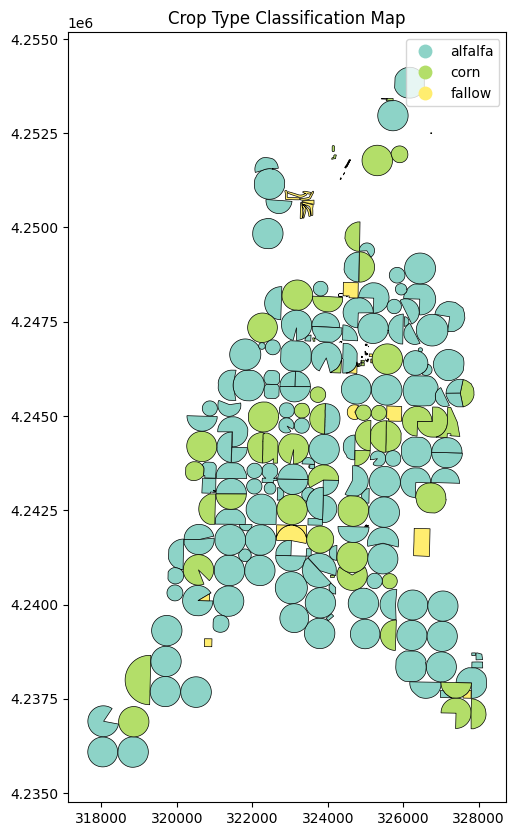

In [23]:
crp_map = pd.concat([pou,results], axis=1, join="inner")
crp_map.to_file("pou_classified.gpkg")
crp_map.plot(column='type', 
                 categorical=True, 
                 legend=True, 
                 figsize=(10,10),
                 cmap='Set3',
                 edgecolor='black',
                 linewidth=0.5)
plt.title("Crop Type Classification Map")